In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report
import joblib
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments
from datasets import Dataset

In [55]:
df = pd.read_csv('WELFake_Dataset.csv')
df = df[['id', 'title', 'text', 'label']]
df.dropna(subset=['text'], inplace=True)
df.fillna('', inplace=True)
df['full_text'] = df['title'] + ' ' + df['text']
df.drop_duplicates(subset='full_text', inplace=True)
df.reset_index(drop=True, inplace=True)

label
0    34791
1    28848
Name: count, dtype: int64
count     63639.000000
mean       3354.240403
std        3636.689325
min           2.000000
25%        1505.000000
50%        2531.000000
75%        4173.500000
max      143035.000000
Name: length, dtype: float64


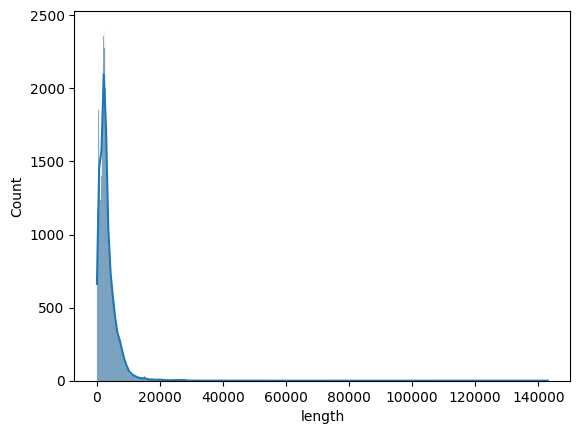

In [104]:
print(df['label'].value_counts())
df['length'] = df['full_text'].str.len()
print(df['length'].describe())
sns.histplot(df['length'], kde=True)
plt.show()

In [97]:
def clean(text):
    text = text.lower()
    text = re.sub(r"http\S+", "", text)
    text = re.sub(r"www\.\S+", "", text)
    news_sources = [
        'reuters', 'breitbart', 'cnn', 'fox news', 'bbc', 'associated press', 'ap news',
        'washington post', 'new york times', 'nytimes', 'huffington post', 'buzzfeed',
        'daily mail', 'guardian', 'independent', 'telegraph', 'times', 'usa today',
        'wall street journal', 'wsj', 'abc news', 'cbs news', 'nbc news', 'msnbc',
        'fox', 'infowars', 'naturalnews', 'zerohedge', 'daily caller', 'daily wire',
        'newsmax', 'oann', 'rt news', 'sputnik', 'drudge report'
    ]
    for source in news_sources:
        text = re.sub(rf'\b{re.escape(source)}\b', '', text, flags=re.IGNORECASE)
        text = re.sub(rf'\b{re.escape(source)}\.com\b', '', text, flags=re.IGNORECASE)
        text = re.sub(rf'\b{re.escape(source)} news\b', '', text, flags=re.IGNORECASE)
    journalism_phrases = [
        'reported by', 'according to sources', 'a spokesperson said',
        'in a statement', 'told reporters', 'source:', 'via twitter',
        'on twitter', 'follow us', 'subscribe to', 'breaking news',
        'this story is developing', 'image via', 'photo credit',
        'washington \\w+', 'new york \\w+', 'london \\w+'
    ]
    for phrase in journalism_phrases:
        text = re.sub(rf'{phrase}', '', text, flags=re.IGNORECASE)
    text = re.sub(r'\b(january|february|march|april|may|june|july|august|september|october|november|december)\s+\d{1,2},?\s+\d{4}\b', '', text, flags=re.IGNORECASE)
    text = re.sub(r'\b\d{1,2}/\d{1,2}/\d{2,4}\b', '', text)
    text = re.sub(r'@\w+', '', text)
    text = re.sub(r'#\w+', '', text)
    text = re.sub(r"[^a-z\s]", "", text)
    text = re.sub(r"\s+", " ", text).strip()
    return text

In [62]:
df['clean_text'] = df['full_text'].apply(clean)
print("Sample cleaned text:")
print(df['clean_text'].iloc[0][:500])

Sample cleaned text:
law enforcement on high alert following threats against cops and whites on by and terrorists video no comment is expected from barack obama members of the or and movements called for the lynching and hanging of white people and cops they encouraged others on a radio show tuesday night to turn the tide and kill white people and cops to send a message about the killing of black people in americaone of the fyoflag organizers is called sunshine she has a radio blog show hosted from texas called suns


In [65]:
def add_content_features(df):
    df['text_length'] = df['clean_text'].str.len()
    df['exclamation_count'] = df['clean_text'].str.count('!')
    df['question_count'] = df['clean_text'].str.count('\\?')
    df['caps_ratio'] = df['clean_text'].str.count('[A-Z]') / df['text_length']
    return df
df=add_content_features(df)

In [66]:
X_train, X_test, y_train, y_test = train_test_split(df['clean_text'], df['label'], test_size=0.2, stratify=df['label'], random_state=42)

In [67]:
vectorizer = TfidfVectorizer(max_features=20000, ngram_range=(1,2), min_df=2, max_df=0.95, stop_words='english')
X_train_vec = vectorizer.fit_transform(X_train)
X_test_vec = vectorizer.transform(X_test)
clf = LogisticRegression(max_iter=1000)
clf.fit(X_train_vec, y_train)
pred_tfidf = clf.predict(X_test_vec)
print("TF-IDF Accuracy:", accuracy_score(y_test, pred_tfidf))
print(classification_report(y_test, pred_tfidf))

TF-IDF Accuracy: 0.9445317410433689
              precision    recall  f1-score   support

           0       0.95      0.95      0.95      6958
           1       0.94      0.94      0.94      5770

    accuracy                           0.94     12728
   macro avg       0.94      0.94      0.94     12728
weighted avg       0.94      0.94      0.94     12728



In [68]:
joblib.dump(vectorizer, 'tfidf_vectorizer.joblib')
joblib.dump(clf, 'logreg_model.joblib')

['logreg_model.joblib']

In [71]:
model_name = "distilbert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_name)
def tokenize_fn(batch):
    return tokenizer(batch['text'], truncation=True, padding='max_length', max_length=512)
train_ds = Dataset.from_dict({'text': X_train.tolist(), 'label': y_train.tolist()})
test_ds = Dataset.from_dict({'text': X_test.tolist(), 'label': y_test.tolist()})
train_ds = train_ds.map(tokenize_fn, batched=True)
test_ds = test_ds.map(tokenize_fn, batched=True)
train_ds.set_format(type='torch', columns=['input_ids', 'attention_mask', 'label'])
test_ds.set_format(type='torch', columns=['input_ids', 'attention_mask', 'label'])

Map:   0%|          | 0/50911 [00:00<?, ? examples/s]

Map:   0%|          | 0/12728 [00:00<?, ? examples/s]

In [72]:
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=2)
args = TrainingArguments(
    output_dir='./transformer',
    eval_strategy='epoch',
    per_device_train_batch_size=8,
    num_train_epochs=1,
    learning_rate=2e-5,
    save_strategy='epoch',
    logging_steps=50,
    save_total_limit=1
)
trainer = Trainer(model=model, args=args, train_dataset=train_ds, eval_dataset=test_ds)
trainer.train()
trainer.evaluate()

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss
1,0.067600,0.060831


{'eval_loss': 0.06083128601312637,
 'eval_runtime': 135.04,
 'eval_samples_per_second': 94.254,
 'eval_steps_per_second': 11.782,
 'epoch': 1.0}

In [73]:
torch.cuda.empty_cache()
model.cpu()

DistilBertForSequenceClassification(
  (distilbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0-5): 6 x TransformerBlock(
          (attention): DistilBertSdpaAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)


In [76]:
trainer.save_model('transformer_model')
tokenizer.save_pretrained('transformer_model')

('transformer_model\\tokenizer_config.json',
 'transformer_model\\special_tokens_map.json',
 'transformer_model\\vocab.txt',
 'transformer_model\\added_tokens.json',
 'transformer_model\\tokenizer.json')

In [77]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

def get_bert_probs(texts, batch_size=16):
    all_probs = []
    for i in range(0, len(texts), batch_size):
        batch = texts[i:i + batch_size]
        inputs = tokenizer(batch, return_tensors='pt', truncation=True, padding=True, max_length=512)
        inputs = {k: v.to(device) for k, v in inputs.items()}
        with torch.no_grad():
            logits = model(**inputs).logits
            probs = torch.nn.functional.softmax(logits, dim=1).cpu().numpy()
            all_probs.append(probs)
    return np.vstack(all_probs)

tfidf_probs = clf.predict_proba(X_test_vec)
bert_probs = get_bert_probs(X_test.tolist())
avg_probs = (tfidf_probs + bert_probs) / 2
ensemble_preds = np.argmax(avg_probs, axis=1)
print("Ensemble Accuracy:", accuracy_score(y_test, ensemble_preds))
print(classification_report(y_test, ensemble_preds))


Ensemble Accuracy: 0.9872721558768071
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      6958
           1       0.99      0.98      0.99      5770

    accuracy                           0.99     12728
   macro avg       0.99      0.99      0.99     12728
weighted avg       0.99      0.99      0.99     12728



In [78]:
import json
scores = {
    'tfidf_acc': accuracy_score(y_test, pred_tfidf),
    'ensemble_acc': accuracy_score(y_test, ensemble_preds)
}
with open('metrics.json', 'w') as f:
    json.dump(scores, f)

In [79]:
def predict(texts):
    clean_texts = [clean(text) for text in texts]
    X_tfidf = vectorizer.transform(clean_texts)
    tfidf_out = clf.predict_proba(X_tfidf)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    enc = tokenizer(texts, return_tensors='pt', truncation=True, padding=True, max_length=512).to(device)
    with torch.no_grad():
        bert_out = model(**enc).logits
        
    bert_probs = torch.nn.functional.softmax(bert_out, dim=1).cpu().numpy()

    final_probs = (tfidf_out + bert_probs) / 2
    return ['real' if p[1] > 0.5 else 'fake' for p in final_probs]

In [80]:
def evaluate_transformer(model, test_dataset):
    predictions = trainer.predict(test_dataset)
    preds = np.argmax(predictions.predictions, axis=1)
    return accuracy_score(test_dataset['label'], preds)

transformer_acc = evaluate_transformer(model, test_ds)
print(f"Transformer Accuracy: {transformer_acc}")

Transformer Accuracy: 0.9855436832181018


In [43]:
from sklearn.model_selection import cross_val_score
cv_scores = cross_val_score(clf, X_train_vec, y_train, cv=5)
print(f"TF-IDF CV Score: {cv_scores.mean():.4f} (+/- {cv_scores.std() * 2:.4f})")

TF-IDF CV Score: 0.9565 (+/- 0.0031)


In [105]:
feature_names = vectorizer.get_feature_names_out()
coef = clf.coef_[0]
top_features = np.argsort(np.abs(coef))[-20:]
print("Top features:")
for idx in reversed(top_features):
    print(f"{feature_names[idx]}: {coef[idx]:.4f}")

Top features:
said: -18.1396
follow: -11.2105
president donald: -9.7833
washington: -9.5154
video: 8.9875
trumps: -8.5001
don: 8.3506
didn: 7.6521
ve: 6.8749
hillary: 6.5485
doesn: 6.5209
thursday: -6.3031
just: 6.2719
tuesday: -6.0054
com: -5.8187
monday: -5.6744
friday: -5.6113
wednesday: -5.5359
images: 5.4953
mr: -5.4687


In [82]:
def explain_prediction(text, top_n=10):
    clean_text = clean(text)
    tfidf_vec = vectorizer.transform([clean_text])
    feature_names = vectorizer.get_feature_names_out()
    scores = (tfidf_vec * clf.coef_).toarray()[0]
    top_indices = np.argsort(np.abs(scores))[-top_n:]
    for idx in reversed(top_indices):
        if scores[idx] != 0:
            print(f"{feature_names[idx]}: {scores[idx]:.4f}")

In [84]:
examples = [
    """Title:
Trump Claims “Presidential DNA” Should Be Registered as National Asset in Surprise Iowa Rally Statement

Abstract:
In a surprise appearance at a local fairground in Des Moines, Iowa, former President Donald J. Trump stunned attendees and political analysts alike by proposing that all former U.S. presidents — starting with himself — should have their DNA registered and preserved as “strategic national assets.”

Speaking to a crowd of roughly 4,000 supporters, Trump deviated from his prepared remarks during a segment on “American greatness” to unveil what he called the Presidential Genome Preservation Act, a policy idea he said would be introduced “day one” if he retakes the White House in 2025. “They say I’m one of the healthiest, most genetically gifted presidents in history — maybe ever,” Trump told the cheering crowd. “We need to protect that DNA. Not just for me, but for future generations. For science. For the Space Force.”

The proposal, which has no precedent in American law or bioethics policy, would reportedly involve collecting and cryogenically storing full genomic data from all living former presidents, beginning with Trump himself. A draft version of the policy — circulated to right-wing think tanks earlier this month — suggests the data could be used in “emergency scenarios involving national leadership restoration or historical cognitive modeling.”

Legal scholars have immediately raised concerns about privacy, bio-sovereignty, and the Constitutionality of compulsory genetic preservation, with Yale Law professor Marsha Kulnick calling it “a bizarre fusion of techno-authoritarian fantasy and reality show science fiction.” Several former presidents’ representatives, including those of Barack Obama and George W. Bush, declined to comment.

""",
    """SAN SALVADOR
Reuters
 — 
A jury in El Salvador sentenced three retired high-ranking military officers to 15 years in prison for the murder of four Dutch journalists in 1982, one of the highest profile cases of the Central American nation’s civil war.

The three were charged on Tuesday for the killings of journalists Koos Joster, Jan Kuiper Joop, Johannes Jan Wilemsen and Hans ter Laag, who were reporting for IKON Television during a 1982 military ambush on a group of former Farabundo Marti National Liberation Front (FMLN) guerrillas - some of whom were armed.

A UN truth commission 11 years later found the ambush was “deliberately planned to surprise and kill the journalists.

The trial was closed and details about the defendants’ pleas and arguments were not made public.

El Salvador’s civil war stretched from 1980 to 1992, pitting leftist guerrillas against the US-backed Salvadoran army and leaving 75,000 people dead and 8,000 more missing.

Former Defense Minister General Jose Guillermo Garcia was sentenced by a jury in the northern town of Chalatenango, alongside two colonels: former Treasury Police chief Francisco Moran and former infantry brigade commander Mario Reyes.
"""
]
print(predict(examples))

['fake', 'fake']


0.9542964051850862
              precision    recall  f1-score   support

        Fake       0.92      0.99      0.95     21417
        Real       0.99      0.92      0.95     23481

    accuracy                           0.95     44898
   macro avg       0.95      0.96      0.95     44898
weighted avg       0.96      0.95      0.95     44898



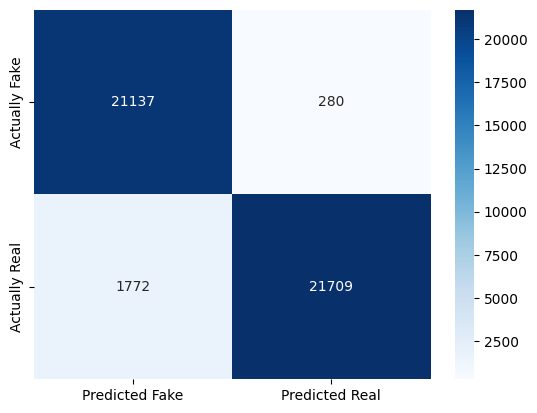

In [ ]:
import pandas as pd
import numpy as np
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import joblib

vectorizer = joblib.load('tfidf_vectorizer.joblib')
clf = joblib.load('logreg_model.joblib')

true_df = pd.read_csv("C:/Users/youne/Desktop/fakenews/True.csv")
false_df = pd.read_csv("C:/Users/youne/Desktop/fakenews/Fake.csv")

true_df['full_text'] = (true_df['title'].fillna('') + ' ' + true_df['text'].fillna('')).astype(str)
false_df['full_text'] = (false_df['title'].fillna('') + ' ' + false_df['text'].fillna('')).astype(str)

texts = true_df['full_text'].tolist() + false_df['full_text'].tolist()
labels = [0] * len(true_df) + [1] * len(false_df)

cleaned_texts = [clean(t) for t in texts]
valid_indices = [i for i, t in enumerate(cleaned_texts) if len(t.strip()) > 10]
cleaned_texts = [cleaned_texts[i] for i in valid_indices]
labels = [labels[i] for i in valid_indices]
X_test = vectorizer.transform(cleaned_texts)
y_pred = clf.predict(X_test)
y_proba = clf.predict_proba(X_test)

acc = accuracy_score(labels, y_pred)
print(acc)
print(classification_report(labels, y_pred, target_names=['Fake', 'Real']))

cm = confusion_matrix(labels, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Predicted Fake', 'Predicted Real'],
            yticklabels=['Actually Fake', 'Actually Real'])
plt.show()
